In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict,
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, precision_recall_curve, 
                            average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import joblib

import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

In [19]:
df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

In [20]:
len(test_df)

4467

In [21]:
df.columns

Index(['id', 'Birth_Date', 'Weight', 'Height', 'Urban_Rural', 'Occupation',
       'Insurance_Type', 'Family_History', 'Cancer_Type', 'Stage_at_Diagnosis',
       'Diagnosis_Date', 'Symptoms', 'Tumor_Size', 'Surgery_Date',
       'Chemotherapy_Drugs', 'Radiation_Sessions', 'Immunotherapy',
       'Targeted_Therapy', 'Recurrence_Status', 'Smoking_History',
       'Alcohol_Use', 'label'],
      dtype='object')

In [22]:
df.head()

,id,Birth_Date,Weight,Height,Urban_Rural,Occupation,Insurance_Type,Family_History,Cancer_Type,Stage_at_Diagnosis,...,Tumor_Size,Surgery_Date,Chemotherapy_Drugs,Radiation_Sessions,Immunotherapy,Targeted_Therapy,Recurrence_Status,Smoking_History,Alcohol_Use,label
0,1,1994-07-01,64.9,155.0cm,Urban,Unemployed,UEBMI,No,Breast,II,...,8.0,2024-10-19,"Paclitaxel,Docetaxel,Doxorubicin",16,No,Yes,NO,Never,Regular,1
1,2,1992-07-16,61.4,171.0cm,Urban,Factory Worker,UEBMI,Yes,Breast,I,...,10.0,2021-02-28,"Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel",10,No,No,Yes,Former,Regular,1
2,3,1948-06-23,60.7,170.0cm,Rural,Unemployed,NRCMS,No,Stomach,IV,...,13.0,2022-09-25,"Fluorouracil,Cisplatin",21,Yes,No,NO,Former,Never,0
3,4,1954-11-26,70.2,171.0cm,Urban,Farmer,URBMI,Yes,Cervical,IV,...,3.0,2024-09-13,Cisplatin,10,No,Yes,NO,Never,Regular,1
4,5,1979-07-08,100.3,186.0cm,Rural,Office Worker,Self-pay,Yes,Lung,II,...,12.0,2023-12-08,"Gemcitabine,Carboplatin",6,Yes,No,Yes,Former,Never,0


In [23]:
df.isna().sum()

id                       0
Birth_Date               0
Weight                   0
Height                   0
Urban_Rural              0
Occupation               0
Insurance_Type           0
Family_History           0
Cancer_Type              0
Stage_at_Diagnosis       0
Diagnosis_Date           0
Symptoms               501
Tumor_Size               0
Surgery_Date          7575
Chemotherapy_Drugs    4050
Radiation_Sessions       0
Immunotherapy            0
Targeted_Therapy         0
Recurrence_Status        0
Smoking_History          0
Alcohol_Use              0
label                    0
dtype: int64

In [24]:
def show_unique_values(df):
    for column in ['Urban_Rural', 'Occupation',
       'Insurance_Type', 'Family_History', 'Cancer_Type', 'Stage_at_Diagnosis',
       'Radiation_Sessions', 'Immunotherapy',
       'Targeted_Therapy', 'Recurrence_Status', 'Smoking_History',
       'Alcohol_Use', 'label']:
        unique_vals = df[column].unique()
        print(f"Column: {column}")
        print(f"Unique Values: {unique_vals}")

# Run the function
show_unique_values(df)

Column: Urban_Rural
Unique Values: ['Urban' 'Rural']
Column: Occupation
Unique Values: ['Unemployed' 'Factory Worker' 'Farmer' 'Office Worker' 'Retired']
Column: Insurance_Type
Unique Values: ['UEBMI' 'NRCMS' 'URBMI' 'Self-pay']
Column: Family_History
Unique Values: ['No' 'Yes']
Column: Cancer_Type
Unique Values: ['Breast' 'Stomach' 'Cervical' 'Lung' 'Esophageal' 'Colorectal' 'Liver']
Column: Stage_at_Diagnosis
Unique Values: ['II' 'I' 'IV' 'III']
Column: Radiation_Sessions
Unique Values: [16 10 21  6 13  4 26 14  7 28  1  0  5 19 27 25 18 17 15 12  8  3  9 24
 11  2 20 23 29 22]
Column: Immunotherapy
Unique Values: ['No' 'Yes']
Column: Targeted_Therapy
Unique Values: ['Yes' 'No']
Column: Recurrence_Status
Unique Values: ['NO' 'Yes']
Column: Smoking_History
Unique Values: ['Never' 'Former' 'Current']
Column: Alcohol_Use
Unique Values: ['Regular' 'Never' 'Occasional']
Column: label
Unique Values: [1 0]


# Preprocessing

In [25]:
def calculate_age(born, diagnosed):
    return diagnosed.year - born.year - ((diagnosed.month, diagnosed.day) < (born.month, born.day))

# Convert dates to datetime
df['Birth_Date'] = pd.to_datetime(df['Birth_Date'], format='%Y-%m-%d', errors='coerce')
df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'], format='%Y-%m-%d', errors='coerce')
df['Surgery_Date'] = pd.to_datetime(df['Surgery_Date'], format='%Y-%m-%d', errors='coerce')

# Create age at diagnosis
df['Age_at_Diagnosis'] = df.apply(lambda x: calculate_age(x['Birth_Date'], x['Diagnosis_Date']), axis=1)

In [26]:
# Create IBM
df['Height'] = df['Height'].str.replace('cm', '').astype(float) / 100
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
df['BMI'] = df['BMI'].round(2) 

In [27]:
# Create surgery delay (days between diagnosis and surgery)
df['Surgery_Delay'] = (df['Surgery_Date'] - df['Diagnosis_Date']).dt.days

# Create had_surgery indicator
df['Had_Surgery'] = df['Surgery_Date'].notna().astype(int)

# Create had_chemotherapy indicator
df['Had_Chemotherapy'] = df['Chemotherapy_Drugs'].notna().astype(int)

# Create symptom count
df['Symptom_Count'] = df['Symptoms'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Create drug count
df['Drug_Count'] = df['Chemotherapy_Drugs'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

In [28]:
stage_map = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
df['Stage_Ordinal'] = df['Stage_at_Diagnosis'].map(stage_map)

In [29]:
## 1. For Chemotherapy Drugs ##

# Split drugs and create list of all unique drugs
all_drugs = set()
df['Chemotherapy_Drugs'].str.split(',').apply(
    lambda x: all_drugs.update([d.strip() for d in x]) 
    if isinstance(x, list) else None
)

print(len(all_drugs))
# Remove empty strings if any
all_drugs = {d for d in all_drugs if d}

# Create binary columns for each drug
for drug in sorted(all_drugs):
    col_name = f"Drug_{drug.replace(' ', '_')}"
    df[col_name] = df['Chemotherapy_Drugs'].apply(
        lambda x: 1 if pd.notna(x) and drug in [d.strip() for d in x.split(',')] else 0
    )

## 2. For Symptoms ##

# Split symptoms and create list of all unique symptoms
all_symptoms = set()
df['Symptoms'].str.split(',').apply(
    lambda x: all_symptoms.update([s.strip() for s in x]) 
    if isinstance(x, list) else None
)
print(len(all_symptoms))
# Remove empty strings if any
all_symptoms = {s for s in all_symptoms if s}

# Create binary columns for each symptom
for symptom in sorted(all_symptoms):
    col_name = f"Symptom_{symptom.replace(' ', '_')}"
    df[col_name] = df['Symptoms'].apply(
        lambda x: 1 if pd.notna(x) and symptom in [s.strip() for s in x.split(',')] else 0
    )

12
9


# Visulaization for insights

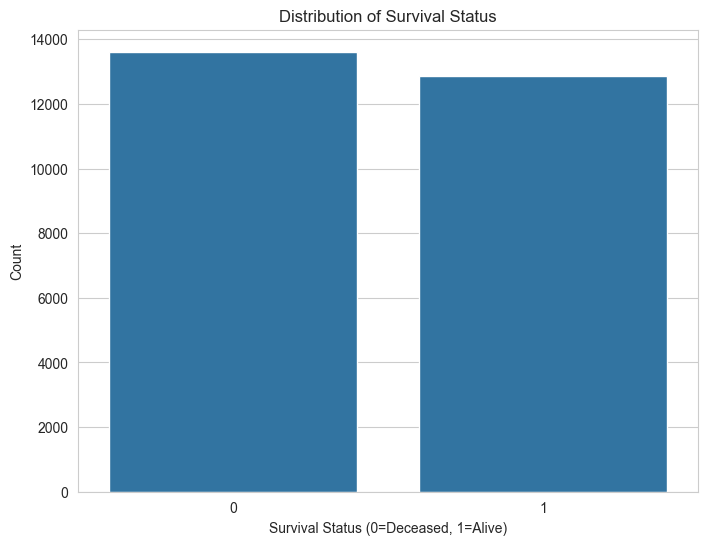

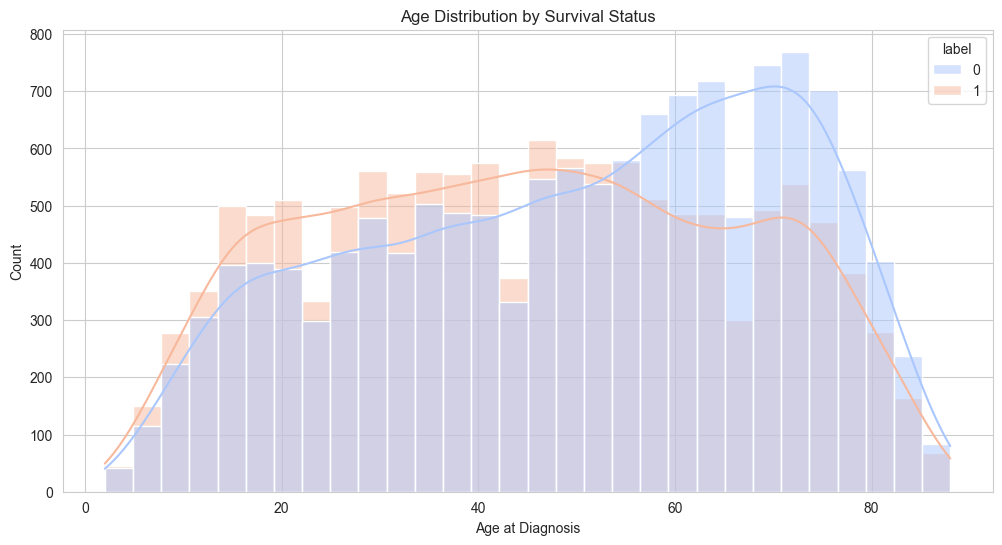

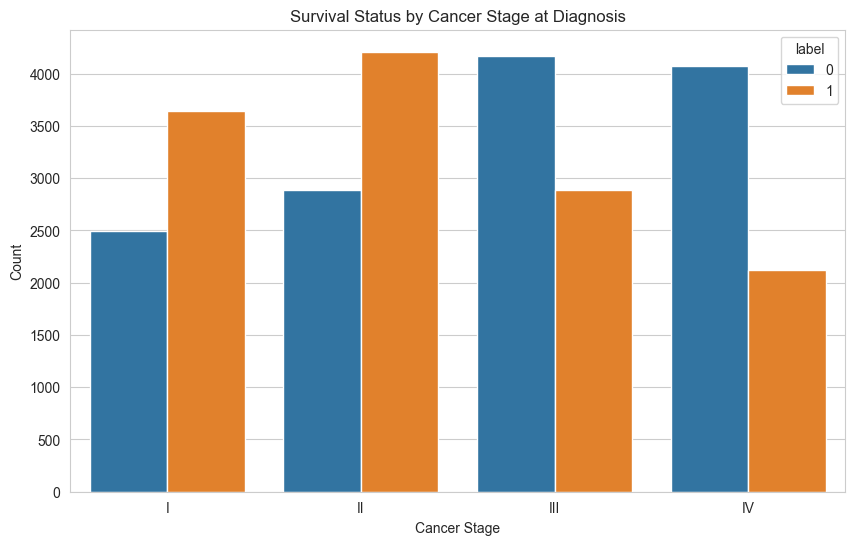

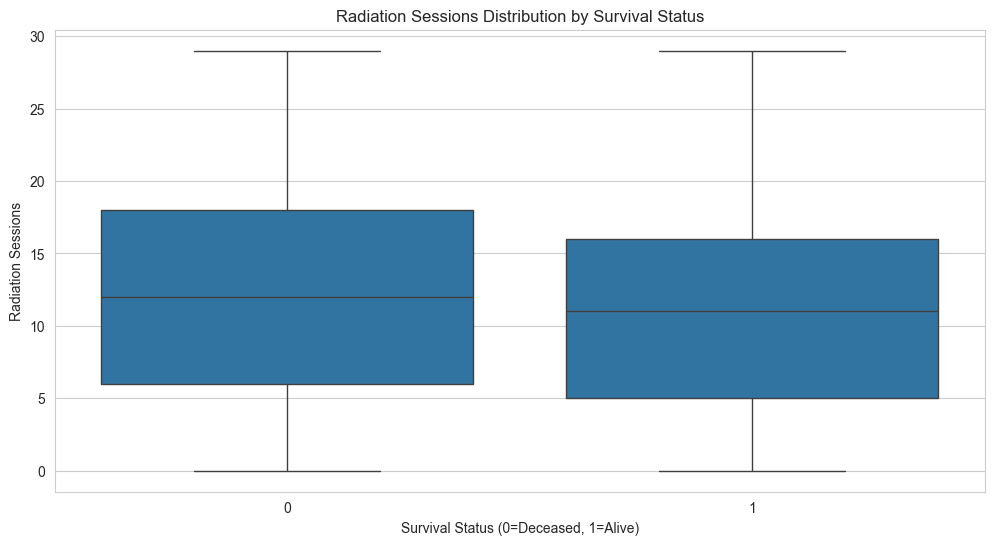

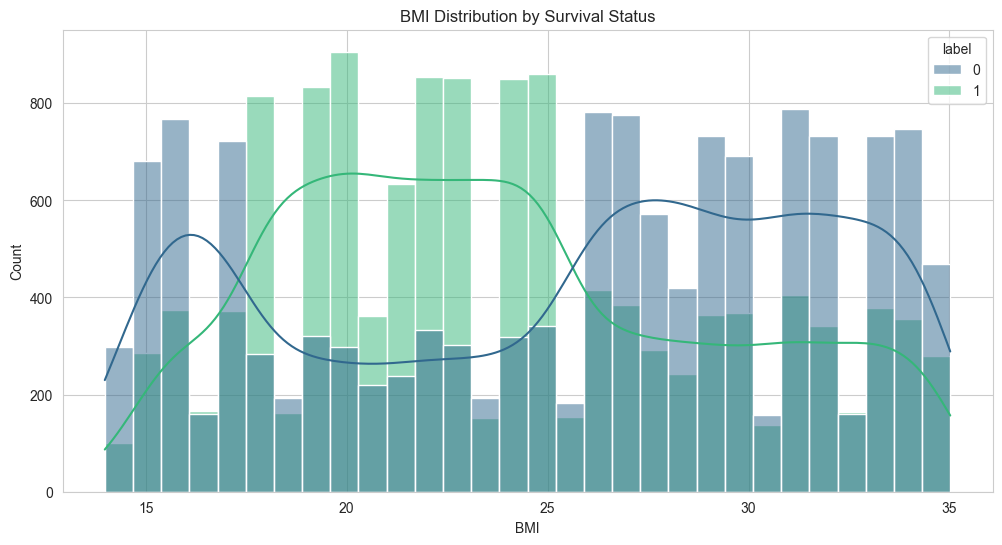

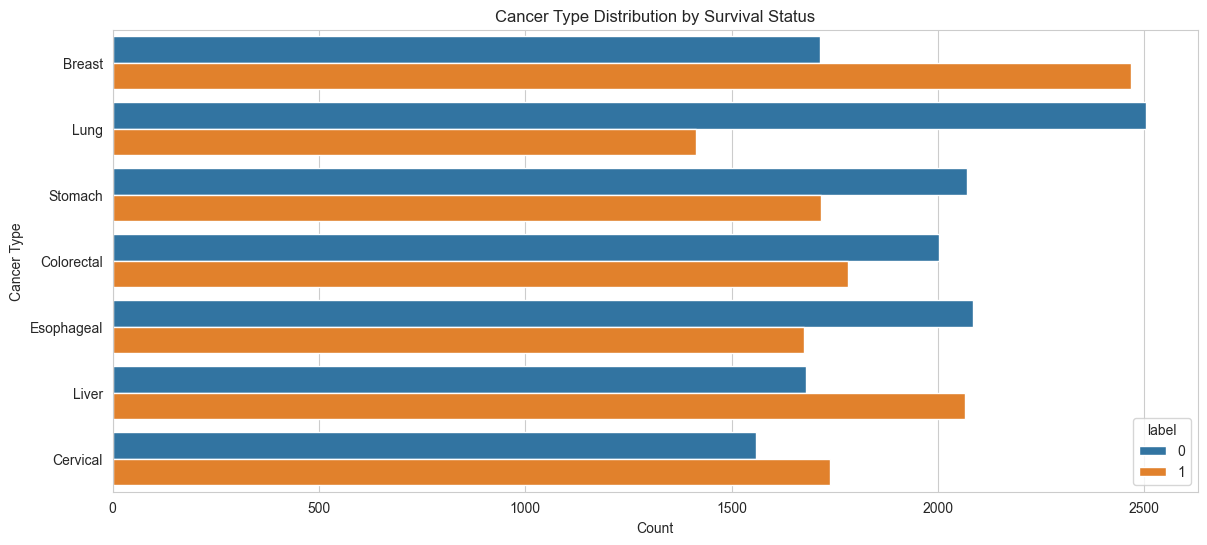

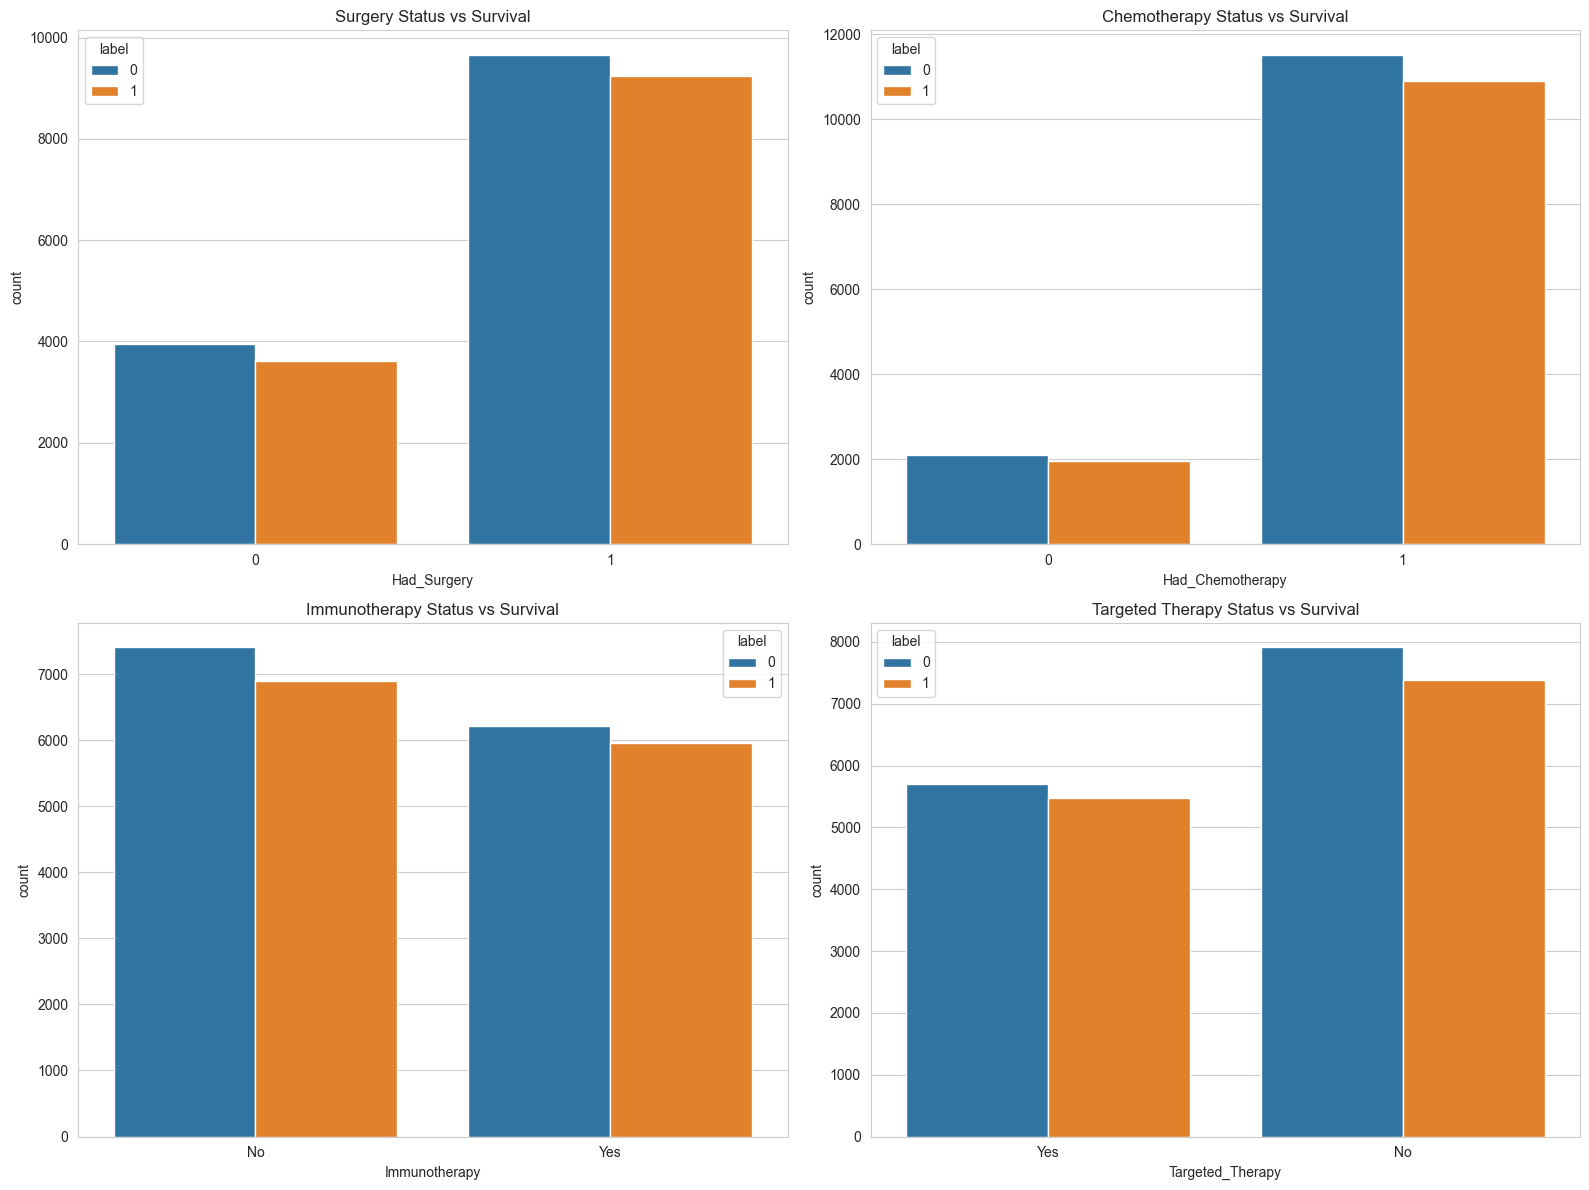

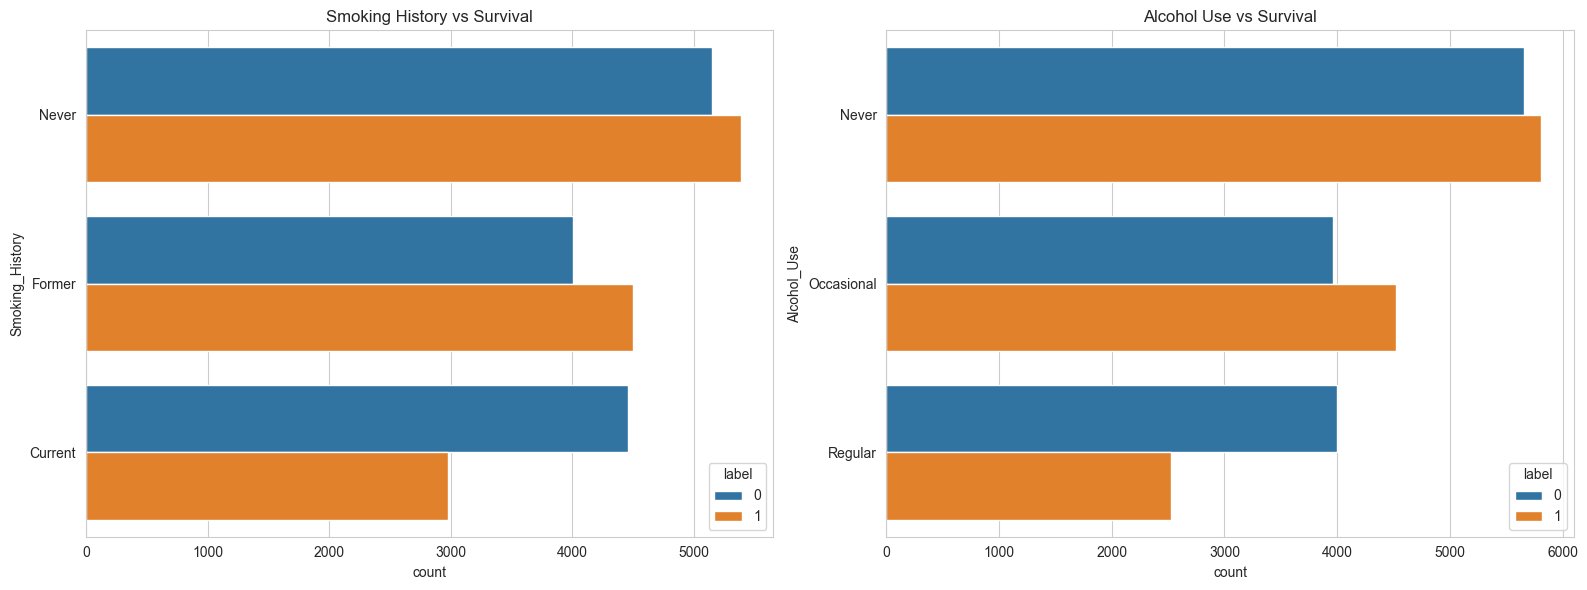

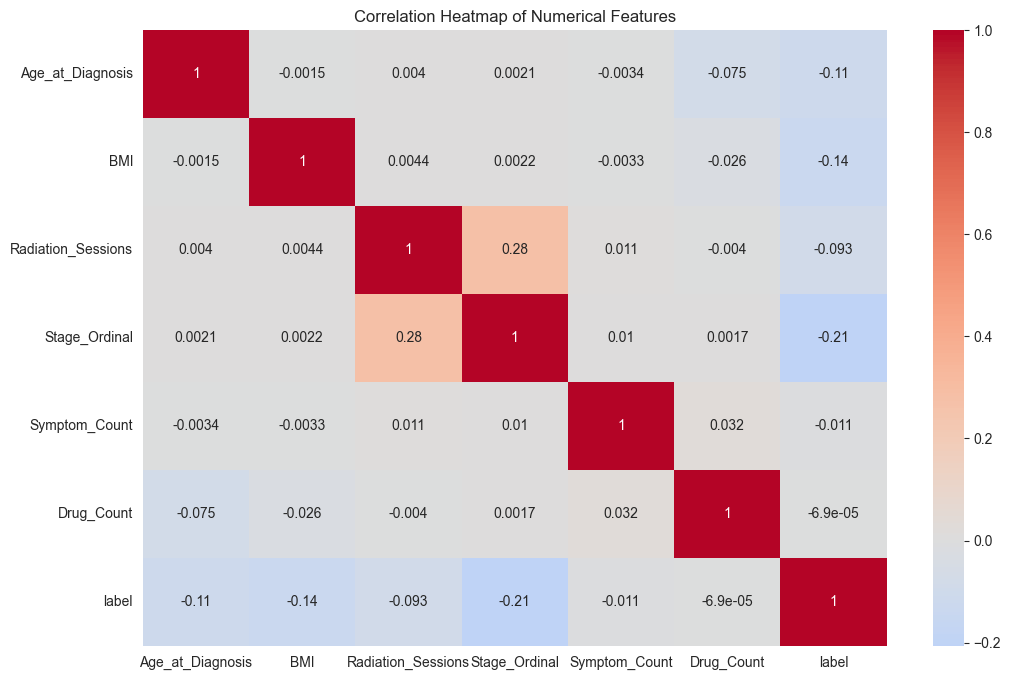

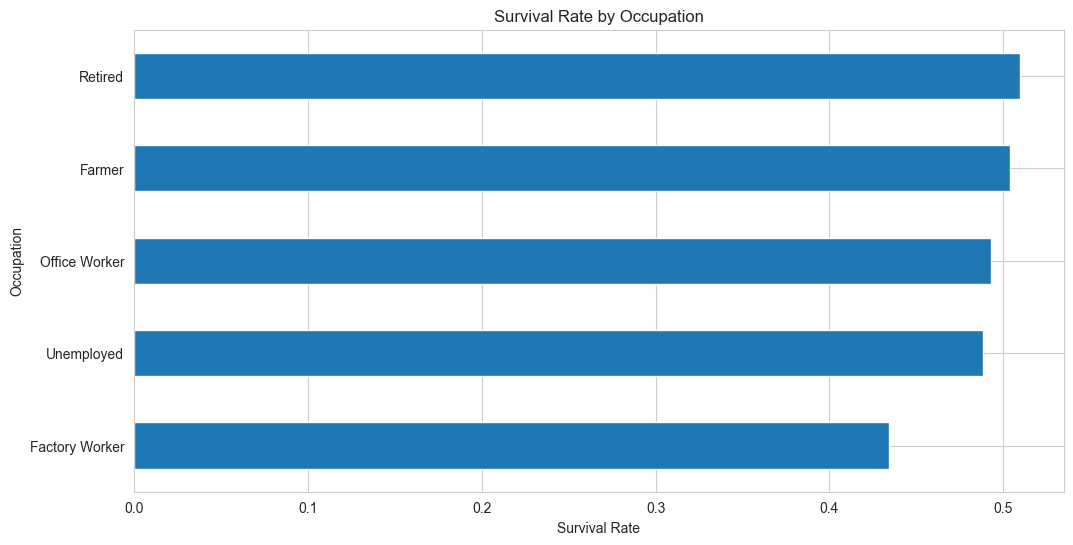

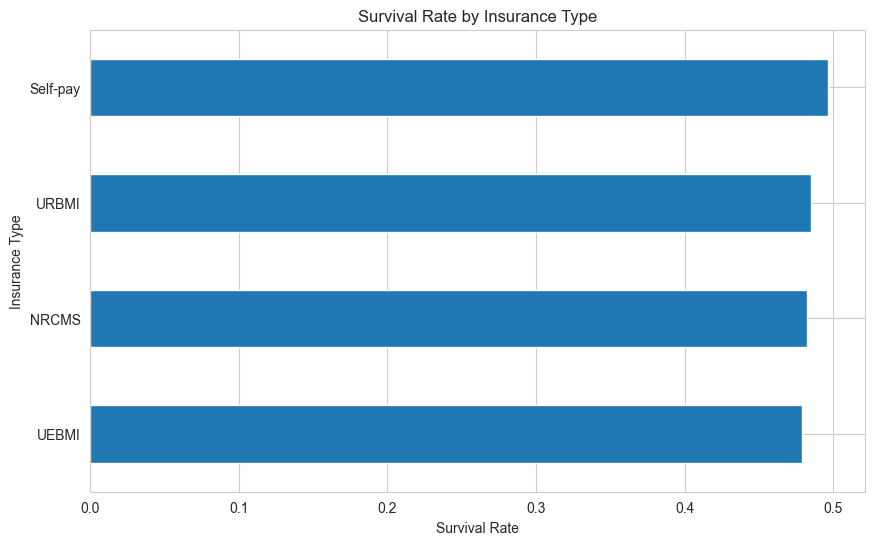

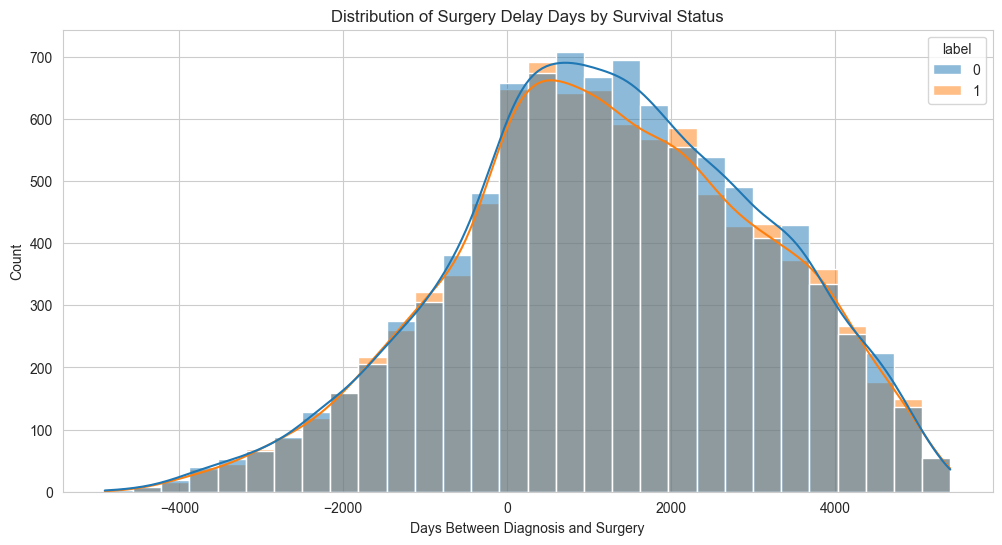

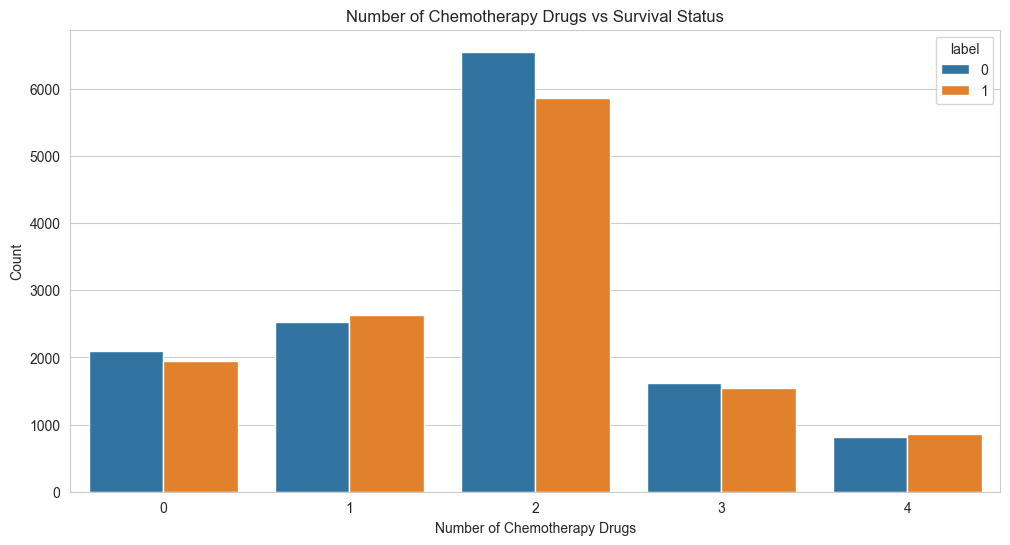

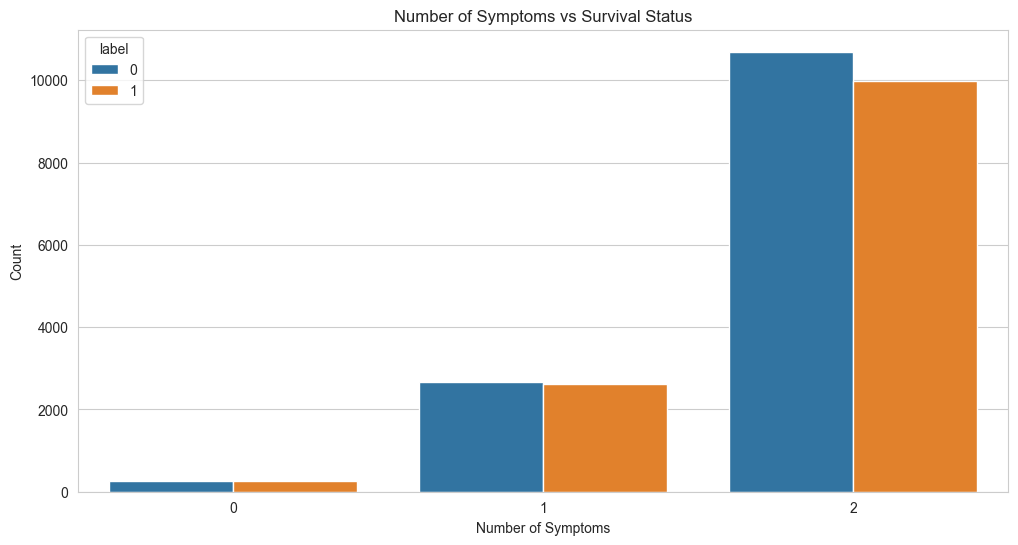

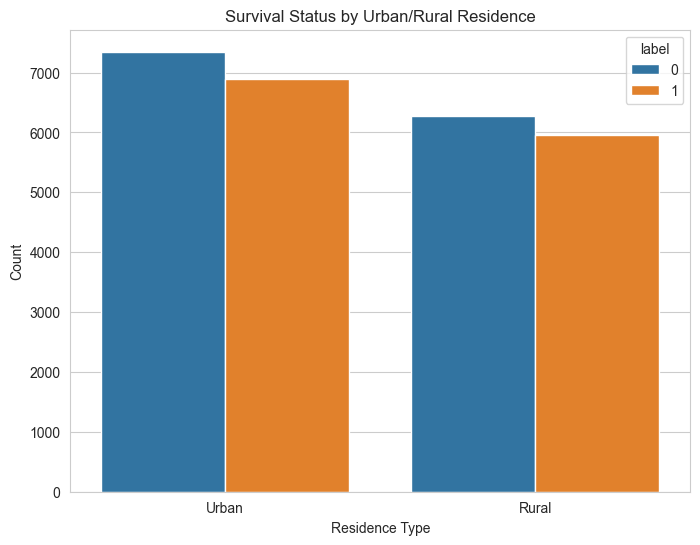

In [30]:
### 1. Target Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Survival Status')
plt.xlabel('Survival Status (0=Deceased, 1=Alive)')
plt.ylabel('Count')
plt.show()

### 2. Age Distribution by Survival Status
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age_at_Diagnosis', hue='label', kde=True, bins=30, palette='coolwarm')
plt.title('Age Distribution by Survival Status')
plt.xlabel('Age at Diagnosis')
plt.ylabel('Count')
plt.show()

### 3. Cancer Stage vs Survival
plt.figure(figsize=(10, 6))
sns.countplot(x='Stage_at_Diagnosis', hue='label', data=df, order=['I', 'II', 'III', 'IV'])
plt.title('Survival Status by Cancer Stage at Diagnosis')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')
plt.show()

### 4. Radiation Sessions vs Survival
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='Radiation_Sessions', data=df)
plt.title('Radiation Sessions Distribution by Survival Status')
plt.xlabel('Survival Status (0=Deceased, 1=Alive)')
plt.ylabel('Radiation Sessions')
plt.show()

### 5. BMI Distribution by Survival
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='BMI', hue='label', kde=True, bins=30, palette='viridis')
plt.title('BMI Distribution by Survival Status')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

### 6. Cancer Type Distribution by Survival
plt.figure(figsize=(14, 6))
sns.countplot(y='Cancer_Type', hue='label', data=df, order=df['Cancer_Type'].value_counts().index)
plt.title('Cancer Type Distribution by Survival Status')
plt.ylabel('Cancer Type')
plt.xlabel('Count')
plt.show()

### 7. Treatment Modalities vs Survival
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.countplot(x='Had_Surgery', hue='label', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Surgery Status vs Survival')

sns.countplot(x='Had_Chemotherapy', hue='label', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Chemotherapy Status vs Survival')

sns.countplot(x='Immunotherapy', hue='label', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Immunotherapy Status vs Survival')

sns.countplot(x='Targeted_Therapy', hue='label', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Targeted Therapy Status vs Survival')

plt.tight_layout()
plt.show()

### 8. Lifestyle Factors
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(y='Smoking_History', hue='label', data=df, ax=axes[0], order=['Never', 'Former', 'Current'])
axes[0].set_title('Smoking History vs Survival')

sns.countplot(y='Alcohol_Use', hue='label', data=df, ax=axes[1], order=['Never', 'Occasional', 'Regular'])
axes[1].set_title('Alcohol Use vs Survival')

plt.tight_layout()
plt.show()

### 9. Correlation Heatmap (for numerical features)
numerical_features = ['Age_at_Diagnosis', 'BMI', 'Radiation_Sessions', 'Stage_Ordinal', 
                     'Symptom_Count', 'Drug_Count', 'label']
plt.figure(figsize=(12, 8))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### 10. Survival Rate by Occupation
occupation_survival = df.groupby('Occupation')['label'].mean().sort_values()
plt.figure(figsize=(12, 6))
occupation_survival.plot(kind='barh')
plt.title('Survival Rate by Occupation')
plt.xlabel('Survival Rate')
plt.ylabel('Occupation')
plt.show()

### 11. Survival Rate by Insurance Type
insurance_survival = df.groupby('Insurance_Type')['label'].mean().sort_values()
plt.figure(figsize=(10, 6))
insurance_survival.plot(kind='barh')
plt.title('Survival Rate by Insurance Type')
plt.xlabel('Survival Rate')
plt.ylabel('Insurance Type')
plt.show()

### 12. Time Between Diagnosis and Surgery (for patients who had surgery)
if df['Had_Surgery'].sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df[df['Had_Surgery']==1], x='Surgery_Delay', hue='label', kde=True, bins=30)
    plt.title('Distribution of Surgery Delay Days by Survival Status')
    plt.xlabel('Days Between Diagnosis and Surgery')
    plt.ylabel('Count')
    plt.show()

### 13. Drug Count vs Survival
plt.figure(figsize=(12, 6))
sns.countplot(x='Drug_Count', hue='label', data=df)
plt.title('Number of Chemotherapy Drugs vs Survival Status')
plt.xlabel('Number of Chemotherapy Drugs')
plt.ylabel('Count')
plt.show()

### 14. Symptom Count vs Survival
plt.figure(figsize=(12, 6))
sns.countplot(x='Symptom_Count', hue='label', data=df)
plt.title('Number of Symptoms vs Survival Status')
plt.xlabel('Number of Symptoms')
plt.ylabel('Count')
plt.show()

### 15. Urban/Rural vs Survival
plt.figure(figsize=(8, 6))
sns.countplot(x='Urban_Rural', hue='label', data=df)
plt.title('Survival Status by Urban/Rural Residence')
plt.xlabel('Residence Type')
plt.ylabel('Count')
plt.show()

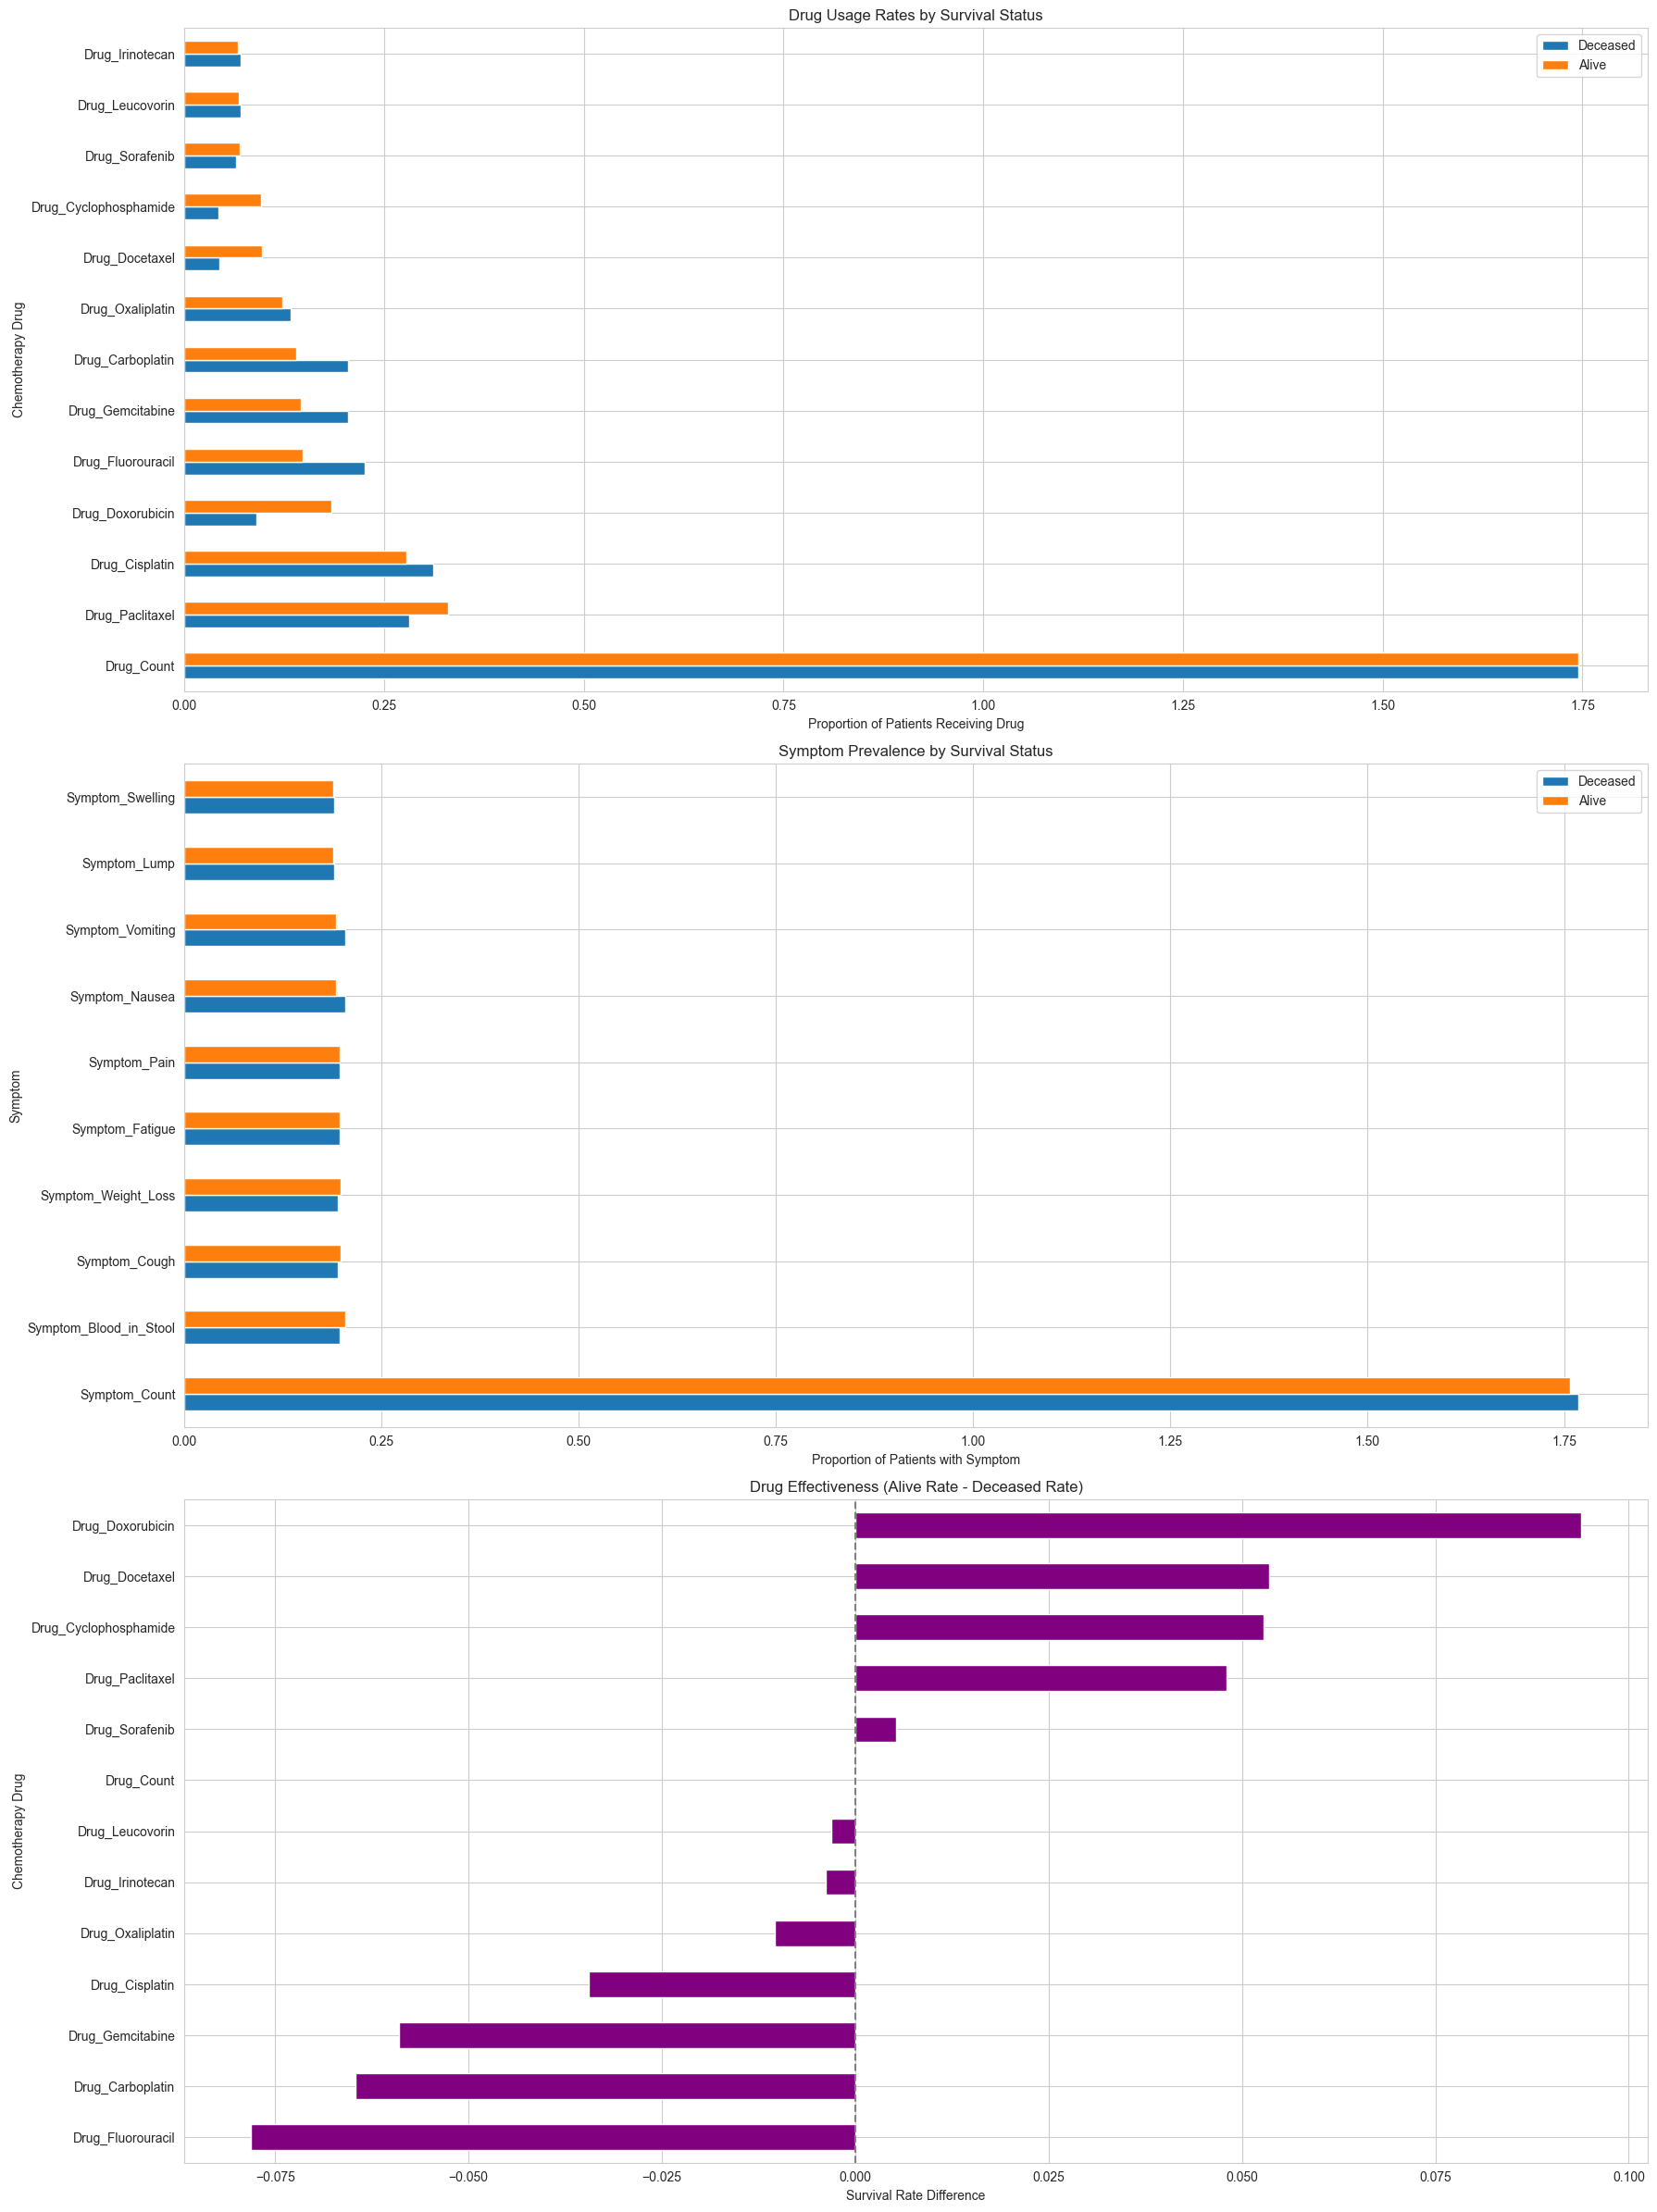

In [31]:
# Set up the figure
plt.figure(figsize=(18, 24))

# Get the top N drugs/symptoms to visualize (avoid overcrowding)
top_drugs = sorted([col for col in df.columns if col.startswith('Drug_')], 
                   key=lambda x: df[x].sum(), reverse=True)[:15]
top_symptoms = sorted([col for col in df.columns if col.startswith('Symptom_')], 
                     key=lambda x: df[x].sum(), reverse=True)[:15]

# Plot drug survival rates
plt.subplot(3, 1, 1)
drug_survival = df.groupby('label')[top_drugs].mean().T.sort_values(1, ascending=False)
drug_survival.plot(kind='barh', stacked=False, ax=plt.gca())
plt.title('Drug Usage Rates by Survival Status')
plt.xlabel('Proportion of Patients Receiving Drug')
plt.ylabel('Chemotherapy Drug')
plt.legend(['Deceased', 'Alive'])

# Plot symptom survival rates
plt.subplot(3, 1, 2)
symptom_survival = df.groupby('label')[top_symptoms].mean().T.sort_values(1, ascending=False)
symptom_survival.plot(kind='barh', stacked=False, ax=plt.gca())
plt.title('Symptom Prevalence by Survival Status')
plt.xlabel('Proportion of Patients with Symptom')
plt.ylabel('Symptom')
plt.legend(['Deceased', 'Alive'])

# Plot drug effectiveness (difference between survival groups)
plt.subplot(3, 1, 3)
drug_effect = drug_survival[1] - drug_survival[0]
drug_effect.sort_values().plot(kind='barh', color='purple')
plt.title('Drug Effectiveness (Alive Rate - Deceased Rate)')
plt.xlabel('Survival Rate Difference')
plt.ylabel('Chemotherapy Drug')
plt.axvline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

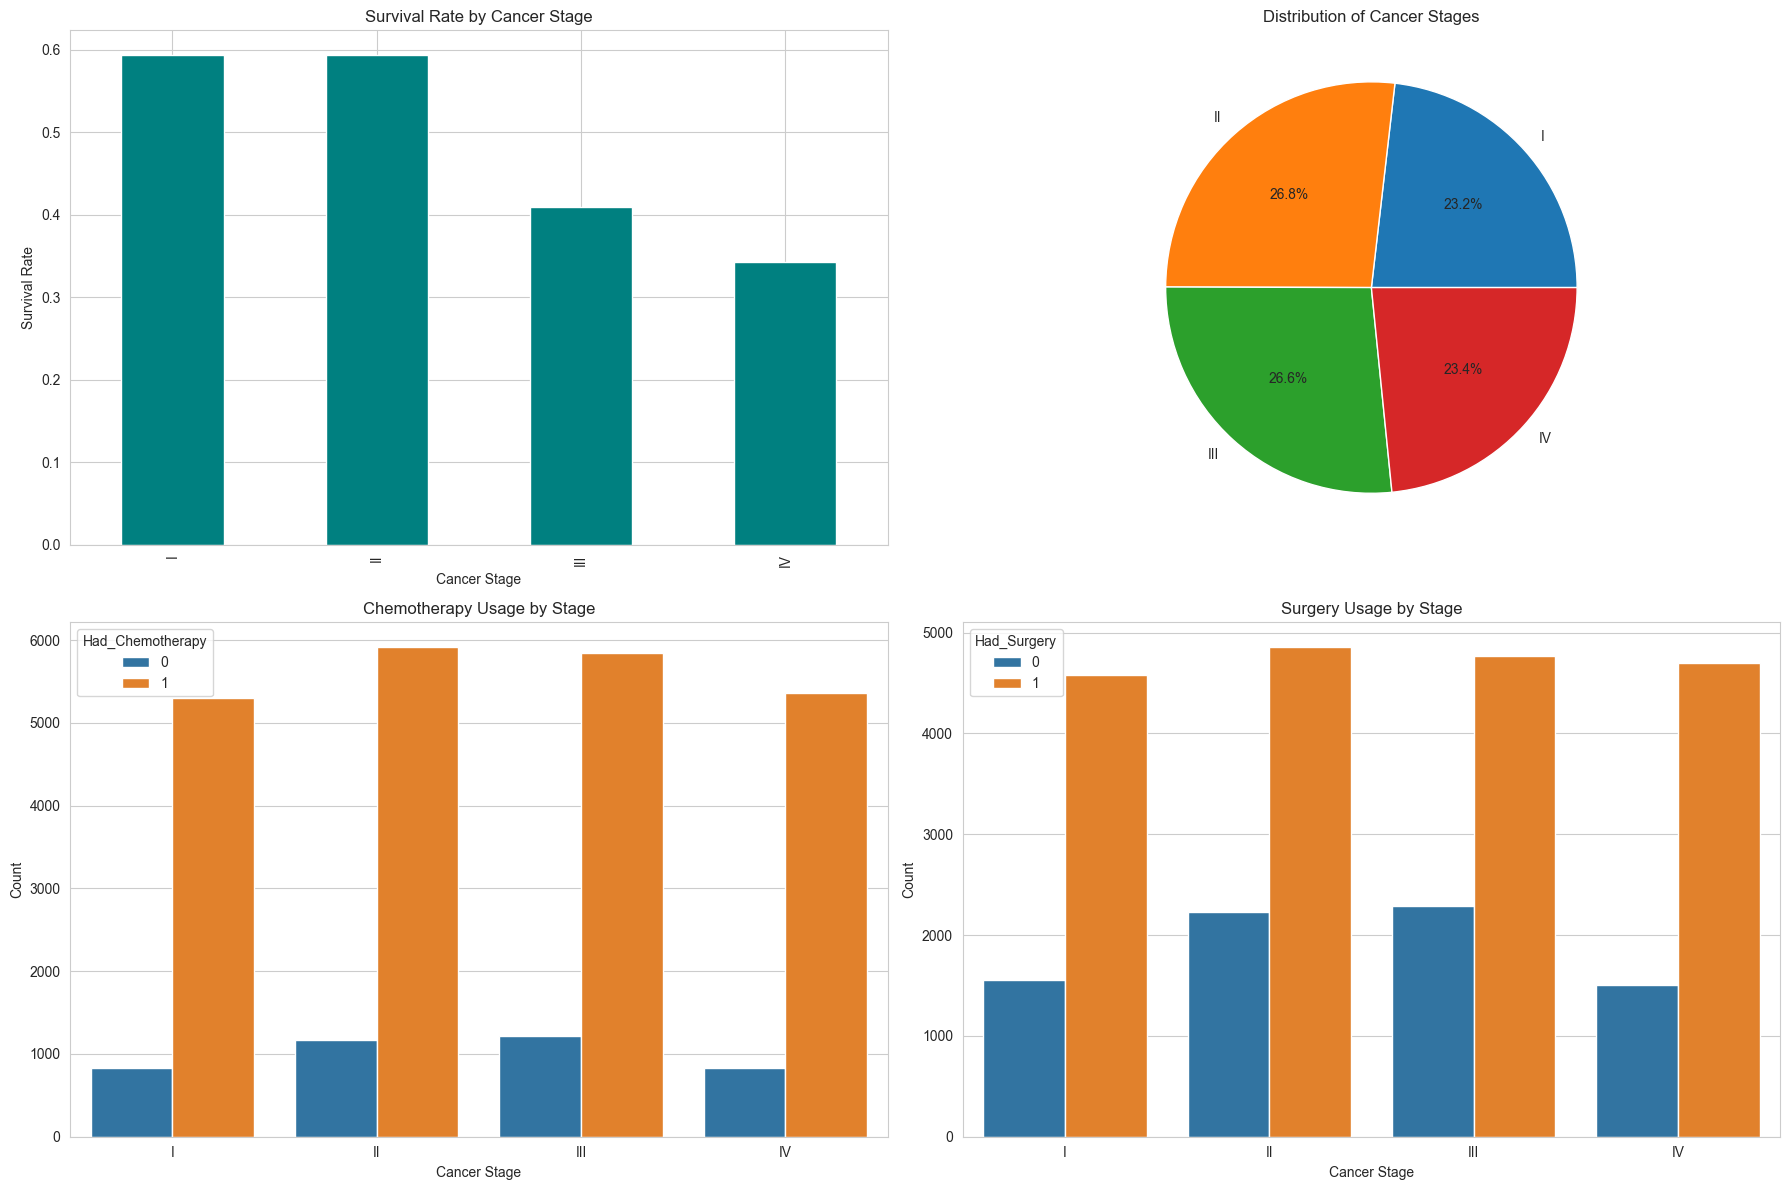

In [32]:
plt.figure(figsize=(18, 12))

# Survival rate by stage
plt.subplot(2, 2, 1)
stage_survival = df.groupby('Stage_at_Diagnosis')['label'].mean().reindex(['I', 'II', 'III', 'IV'])
stage_survival.plot(kind='bar', color='teal')
plt.title('Survival Rate by Cancer Stage')
plt.ylabel('Survival Rate')
plt.xlabel('Cancer Stage')

# Stage distribution
plt.subplot(2, 2, 2)
df['Stage_at_Diagnosis'].value_counts().reindex(['I', 'II', 'III', 'IV']).plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Cancer Stages')
plt.ylabel('')

# Treatment modalities by stage
plt.subplot(2, 2, 3)
sns.countplot(x='Stage_at_Diagnosis', hue='Had_Chemotherapy', data=df, order=['I', 'II', 'III', 'IV'])
plt.title('Chemotherapy Usage by Stage')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
sns.countplot(x='Stage_at_Diagnosis', hue='Had_Surgery', data=df, order=['I', 'II', 'III', 'IV'])
plt.title('Surgery Usage by Stage')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

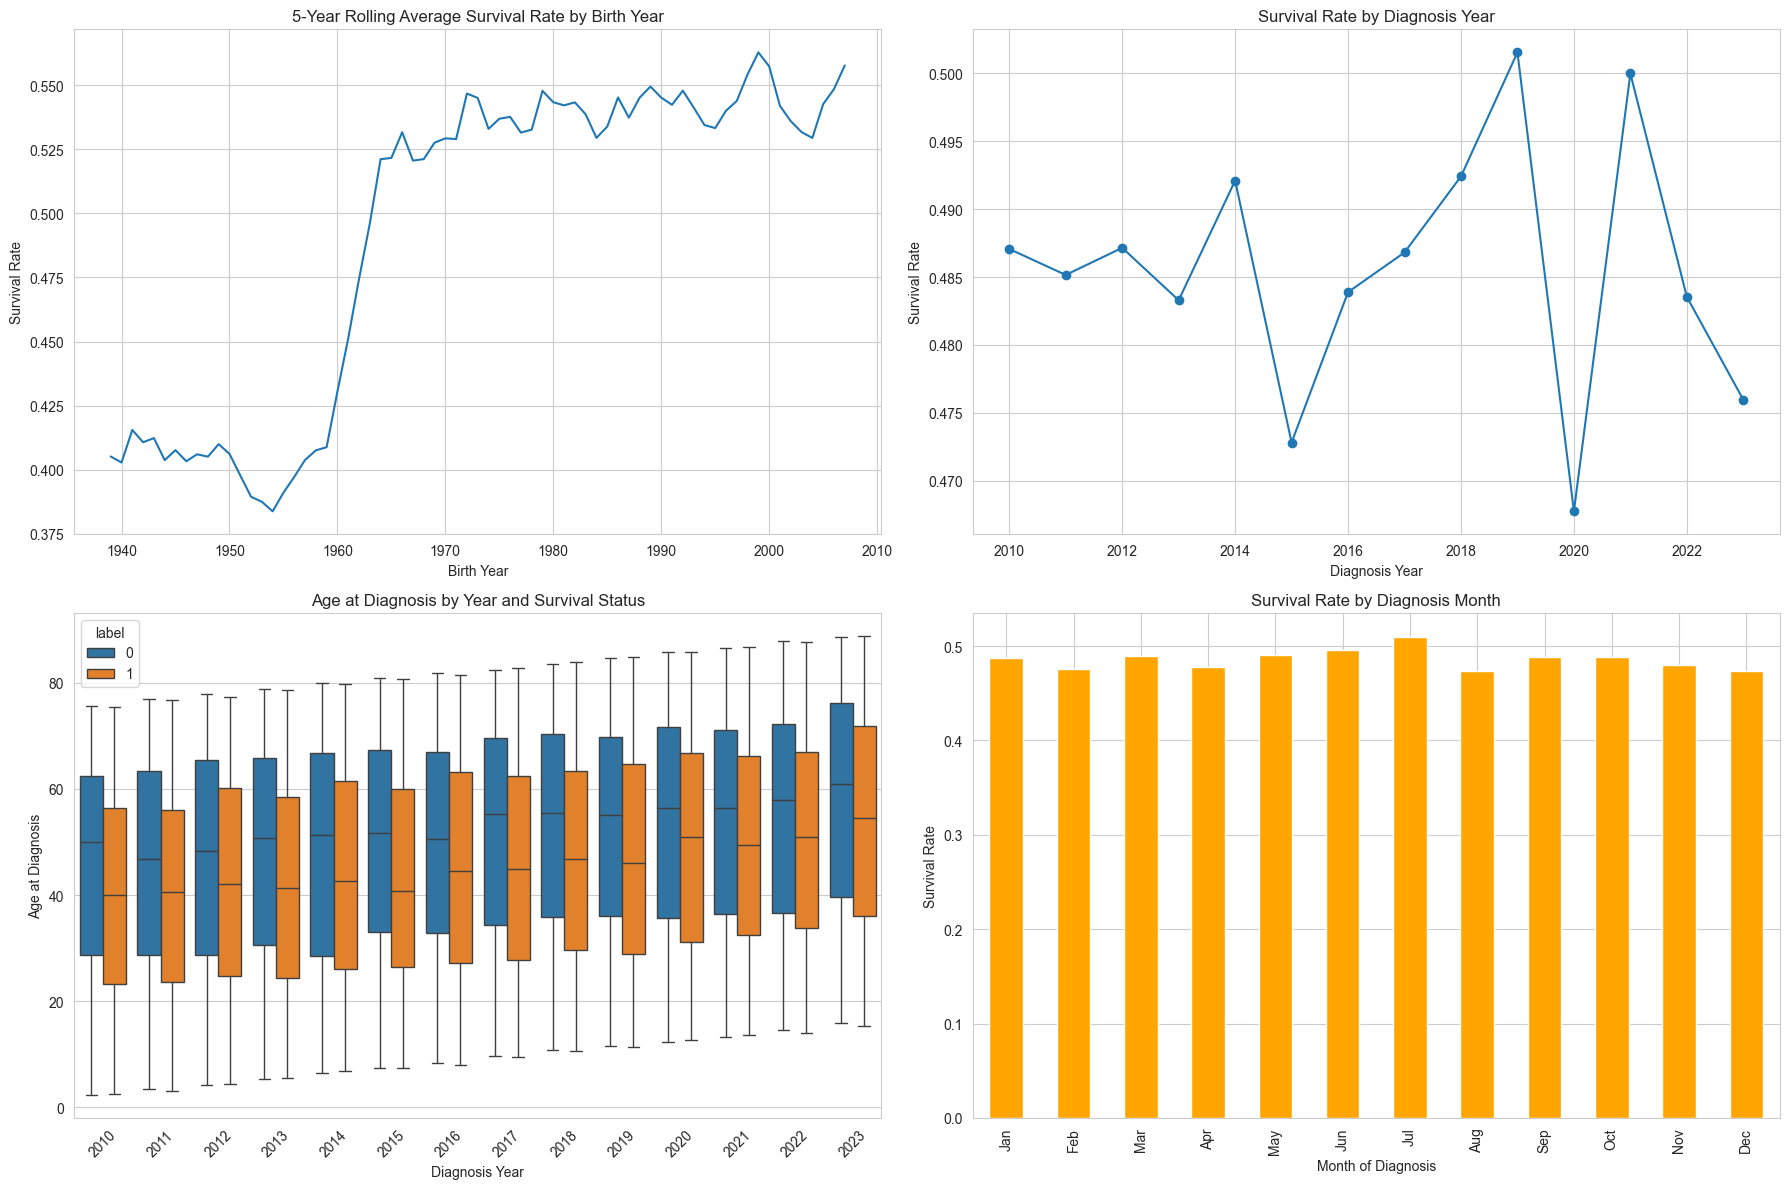

In [33]:
plt.figure(figsize=(18, 12))

# Convert dates to datetime if not already
df['Birth_Date'] = pd.to_datetime(df['Birth_Date'])
df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'])

# Birth year analysis
plt.subplot(2, 2, 1)
df['Birth_Year'] = df['Birth_Date'].dt.year
birth_year_survival = df.groupby('Birth_Year')['label'].mean()
birth_year_survival.rolling(5).mean().plot()
plt.title('5-Year Rolling Average Survival Rate by Birth Year')
plt.ylabel('Survival Rate')
plt.xlabel('Birth Year')

# Diagnosis year analysis
plt.subplot(2, 2, 2)
df['Diagnosis_Year'] = df['Diagnosis_Date'].dt.year
diagnosis_year_survival = df.groupby('Diagnosis_Year')['label'].mean()
diagnosis_year_survival.plot(marker='o')
plt.title('Survival Rate by Diagnosis Year')
plt.ylabel('Survival Rate')
plt.xlabel('Diagnosis Year')

# Age at diagnosis trends
plt.subplot(2, 2, 3)
df['Age_at_Diagnosis'] = (df['Diagnosis_Date'] - df['Birth_Date']).dt.days / 365.25
sns.boxplot(x='Diagnosis_Year', y='Age_at_Diagnosis', hue='label', data=df)
plt.title('Age at Diagnosis by Year and Survival Status')
plt.ylabel('Age at Diagnosis')
plt.xlabel('Diagnosis Year')
plt.xticks(rotation=45)

# Monthly diagnosis patterns
plt.subplot(2, 2, 4)
df['Diagnosis_Month'] = df['Diagnosis_Date'].dt.month
monthly_survival = df.groupby('Diagnosis_Month')['label'].mean()
monthly_survival.plot(kind='bar', color='orange')
plt.title('Survival Rate by Diagnosis Month')
plt.ylabel('Survival Rate')
plt.xlabel('Month of Diagnosis')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

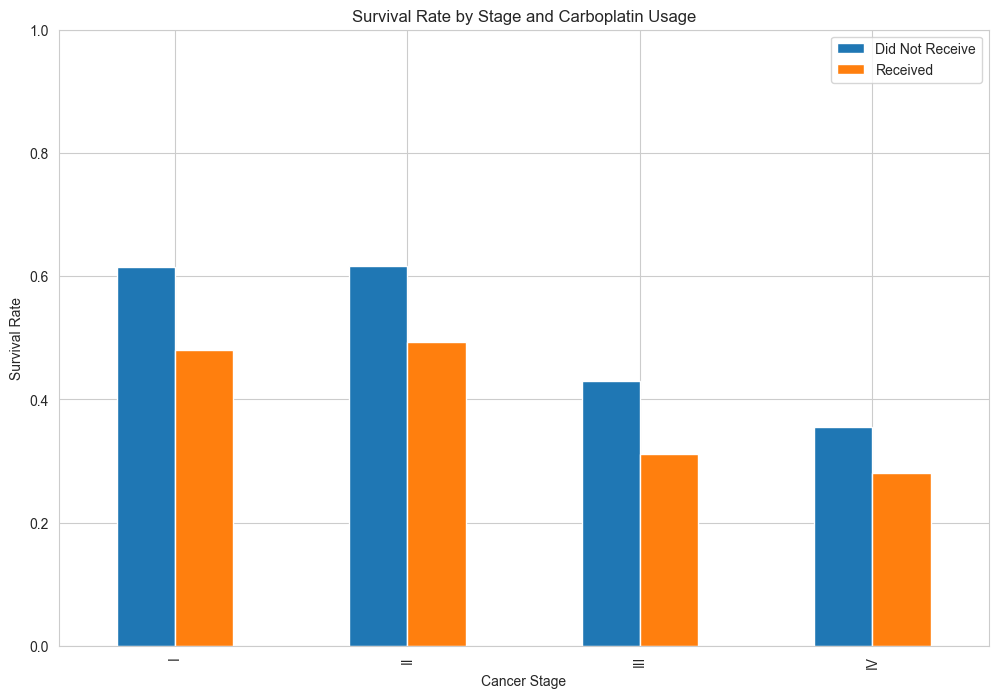

<Figure size 1000x600 with 0 Axes>

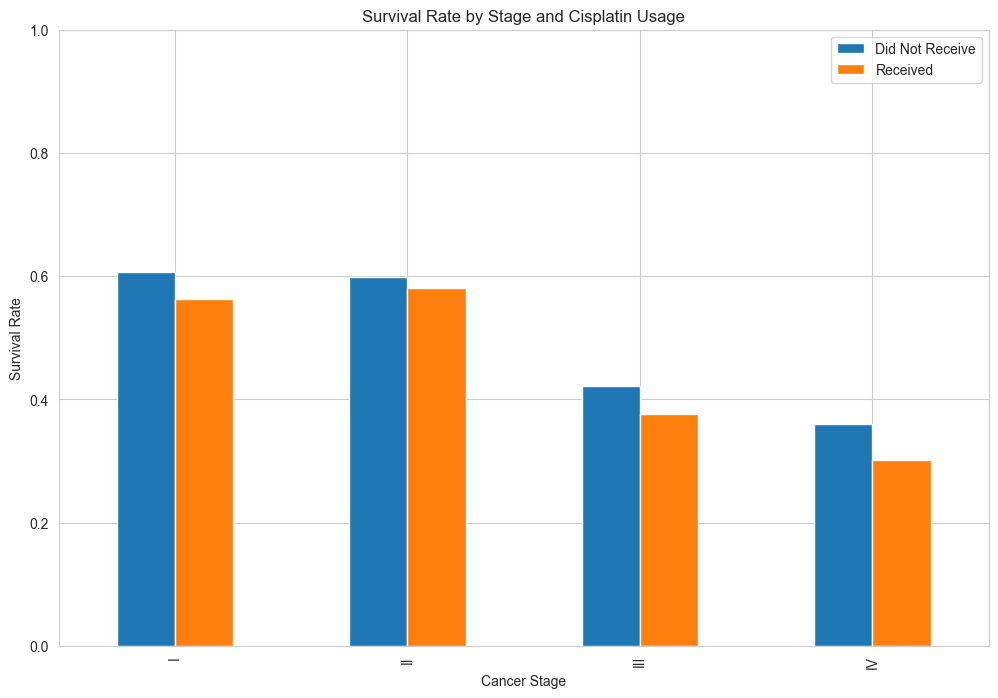

<Figure size 1000x600 with 0 Axes>

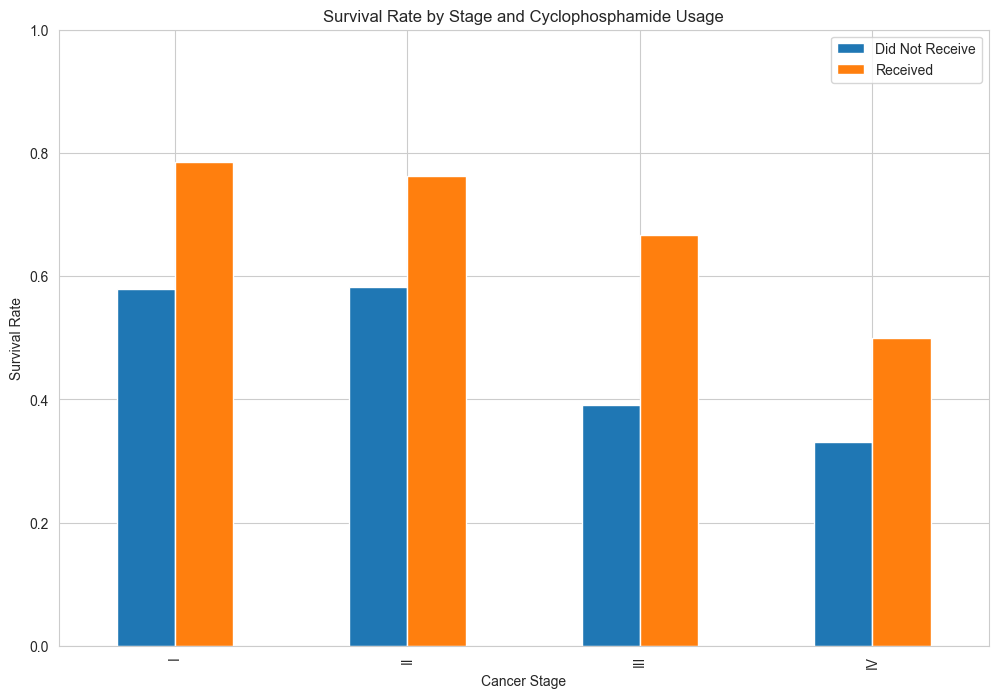

In [37]:
# Create a pivot table for drug effectiveness by stage
top_3_drugs = [col for col in df.columns if col.startswith('Drug_')][1:4]
for drug in top_3_drugs:
    plt.figure(figsize=(10, 6))
    pivot = pd.pivot_table(df, values='label', index='Stage_at_Diagnosis', 
                          columns=drug, aggfunc='mean')
    pivot.plot(kind='bar')
    plt.title(f'Survival Rate by Stage and {drug.replace("Drug_", "")} Usage')
    plt.ylabel('Survival Rate')
    plt.xlabel('Cancer Stage')
    plt.legend(['Did Not Receive', 'Received'])
    plt.ylim(0, 1)
    plt.show()

In [38]:
df.columns

Index(['id', 'Birth_Date', 'Weight', 'Height', 'Urban_Rural', 'Occupation',
       'Insurance_Type', 'Family_History', 'Cancer_Type', 'Stage_at_Diagnosis',
       'Diagnosis_Date', 'Symptoms', 'Tumor_Size', 'Surgery_Date',
       'Chemotherapy_Drugs', 'Radiation_Sessions', 'Immunotherapy',
       'Targeted_Therapy', 'Recurrence_Status', 'Smoking_History',
       'Alcohol_Use', 'label', 'Age_at_Diagnosis', 'BMI', 'Surgery_Delay',
       'Had_Surgery', 'Had_Chemotherapy', 'Symptom_Count', 'Drug_Count',
       'Stage_Ordinal', 'Drug_Carboplatin', 'Drug_Cisplatin',
       'Drug_Cyclophosphamide', 'Drug_Docetaxel', 'Drug_Doxorubicin',
       'Drug_Fluorouracil', 'Drug_Gemcitabine', 'Drug_Irinotecan',
       'Drug_Leucovorin', 'Drug_Oxaliplatin', 'Drug_Paclitaxel',
       'Drug_Sorafenib', 'Symptom_Blood_in_Stool', 'Symptom_Cough',
       'Symptom_Fatigue', 'Symptom_Lump', 'Symptom_Nausea', 'Symptom_Pain',
       'Symptom_Swelling', 'Symptom_Vomiting', 'Symptom_Weight_Loss',
       'Birth_Ye

In [42]:
# Get all drug and symptom columns
all_drug_columns = [col for col in df.columns if col.startswith('Drug_')]
all_symptom_columns = [col for col in df.columns if col.startswith('Symptom_')]

# Define feature columns
useful_features = [
    # Demographic
    'Age_at_Diagnosis', 'BMI', 'Urban_Rural', 'Insurance_Type', 
    
    # Cancer characteristics
    'Cancer_Type', 'Stage_Ordinal', 'Tumor_Size', 'Recurrence_Status',
    
    # Treatment related
    'Had_Surgery', 'Surgery_Delay', 'Had_Chemotherapy', 'Radiation_Sessions',
    'Immunotherapy', 'Targeted_Therapy', 'Drug_Count',
    
    # All drugs and symptoms
    *all_drug_columns,
    *all_symptom_columns,
    
    # Lifestyle
    'Smoking_History', 'Alcohol_Use',
    
    # Temporal
    'Diagnosis_Year'
]

# Separate features and target
X = df[useful_features]
y = df['label']

# Define categorical and numerical features
categorical_features = [
    'Urban_Rural', 'Insurance_Type', 'Cancer_Type', 
    'Recurrence_Status', 'Immunotherapy', 'Targeted_Therapy',
    'Smoking_History', 'Alcohol_Use'
]

numerical_features = [
    'Age_at_Diagnosis', 'BMI', 'Stage_Ordinal', 'Tumor_Size',
    'Surgery_Delay', 'Radiation_Sessions', 'Drug_Count',
    'Diagnosis_Year'
]

# Binary features (drugs and symptoms)
binary_features = all_drug_columns + all_symptom_columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', 'passthrough', binary_features)
    ])

In [43]:
# Split into train and validation sets (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Define models with class weight balancing
models = {
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # Handle imbalance
        use_label_encoder=False
    ),
    'LightGBM': LGBMClassifier(
        random_state=42,
        is_unbalance=True  # Automatically adjusts for imbalanced data
    ),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        auto_class_weights='Balanced',  # Automatic class weighting
        verbose=0
    ),
    'RandomForest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    )
}

# Set up 5-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

def find_optimal_threshold(y_true, y_proba):
    """Find optimal threshold using precision-recall curve"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # Use F2 score to emphasize recall (more important for medical diagnosis)
    f2_scores = (5 * precision * recall) / (4 * precision + recall + 1e-9)
    optimal_idx = np.argmax(f2_scores)
    return thresholds[optimal_idx]

# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline with SMOTE and feature selection
    pipeline = make_imb_pipeline(
        preprocessor,
        SelectKBest(f_classif, k='all'),  # Keep all features initially
        SMOTE(random_state=42),
        model
    )
    
    # Get cross-validated probabilities
    y_proba = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    
    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(y_train, y_proba)
    print(f"Optimal threshold for {name}: {optimal_threshold:.4f}")
    
    # Convert to class predictions using optimal threshold
    y_pred = (y_proba > optimal_threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    roc_auc = roc_auc_score(y_train, y_proba)
    pr_auc = average_precision_score(y_train, y_proba)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'Optimal Threshold': optimal_threshold
    })
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.sort_values('ROC AUC', ascending=False))

NameError: name 'train_test_split' is not defined